In [3]:
import tensorflow as tf
# import tensorflow_addons as tfa
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime



ModuleNotFoundError: No module named 'cv2'

In [2]:
tf.__version__

'2.15.0'

In [4]:
tf.config.list_logical_devices('GPU')

[]

In [5]:
(tf.__version__)

'2.15.0'

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [2]:


# Load CSV file with image file names and labels
csv_path = 'train/train/train.csv'  
data = pd.read_csv(csv_path)

# Path to the folder containing the images
image_folder = 'train/train/images'  

# Function to load and preprocess images
def load_and_preprocess_images(file_paths, target_size=(224, 224)):
    images = []
    for file_path in file_paths:
        image = cv2.imread(os.path.join(image_folder, file_path))
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Load and preprocess images
images = load_and_preprocess_images(data['filename'])

# Encode labels (assuming labels are in 1, 2, 3, 4, 5, 6 format)
labels = data['label'] - 1  # Subtract 1 to convert to 0-based indices

# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Print shapes for verification
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (5760, 224, 224, 3)
Train Labels Shape: (5760,)
Validation Images Shape: (1440, 224, 224, 3)
Validation Labels Shape: (1440,)


In [3]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [4]:
# Set checkpoint path

checkpoint_path = "models/checkpoint.ckpt"

# Create a MOdelCheckpoint callback that saves the model's weights only
checkpoint_callbck = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        save_freq="epoch",
                                                        verbose=1)

In [5]:

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [6]:
def test_prediction(model):

    # Load the test data CSV file
    test_csv_path = 'test/test/test.csv'  # Replace with the actual path
    test_data = pd.read_csv(test_csv_path)

    # Path to the folder containing test images
    test_image_folder = 'test/test/images'  # Replace with the actual path

    # Function to load and preprocess test images
    def load_and_preprocess_test_images(file_paths, target_size=(224, 224)):
        images = []
        for file_path in file_paths:
            image = cv2.imread(os.path.join(test_image_folder, file_path))
            image = cv2.resize(image, target_size)
            image = image.astype('float32') / 255.0  # Normalize pixel values
            images.append(image)
        return np.array(images)

    # Load and preprocess test images
    test_images = load_and_preprocess_test_images(test_data['filename'])



    # Enable memory debugging
    tf.debugging.experimental.enable_dump_debug_info("memory_debug")

    # Make predictions
    predictions = model.predict(test_images)

    # Disable memory debugging
    tf.debugging.experimental.disable_dump_debug_info()


    # Assign labels based on the predicted probabilities
    predicted_labels = np.argmax(predictions, axis=1)

    # Add predicted labels to the test data DataFrame
    test_data['predicted_label'] = predicted_labels + 1  # Add 1 to convert back to 1-indexed labels

    # Save the updated test data CSV file
    test_data.to_csv('Results/result.csv', index=False)  # Replace with the desired path


In [13]:
# 1. Create a base model tf.keras.application

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet")

# 2. freeze the base model
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. for resnet

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Avarage pool outputs of the model (aggregation all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "Gloabal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(6, activation="softmax", name="output_layer")(x)

# 8. combine the inputes with the outputs into a model
tl_model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
tl_model_0.compile(loss= "sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




Shape after passing inputs through base model: (None, 1000)


ValueError: Input 0 of layer "Gloabal_average_pooling_layer" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 1000)

In [ ]:
# Train the model
history_tl_model_0 = tl_model_0.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="tl_model_0"),
                                             checkpoint_callbck])

Saving TensorBoard log files to: models/tl_model_0/20231203-203426
Epoch 1/10
180/180 [==============================] - ETA: 0s - loss: 1.5765 - accuracy: 0.3122
Epoch 1: val_loss improved from inf to 1.55356, saving model to models\checkpoint.ckpt
180/180 [==============================] - 104s 551ms/step - loss: 1.5765 - accuracy: 0.3122 - val_loss: 1.5536 - val_accuracy: 0.3306
Epoch 2/10
180/180 [==============================] - ETA: 0s - loss: 1.5713 - accuracy: 0.3104
Epoch 2: val_loss did not improve from 1.55356
180/180 [==============================] - 89s 494ms/step - loss: 1.5713 - accuracy: 0.3104 - val_loss: 1.5589 - val_accuracy: 0.3285
Epoch 3/10
 71/180 [==========>...................] - ETA: 43s - loss: 1.5829 - accuracy: 0.3169

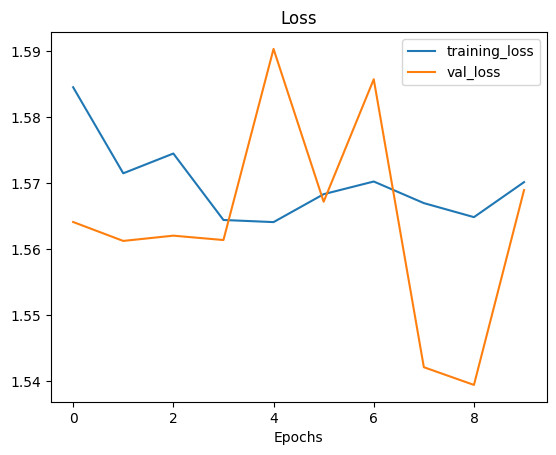

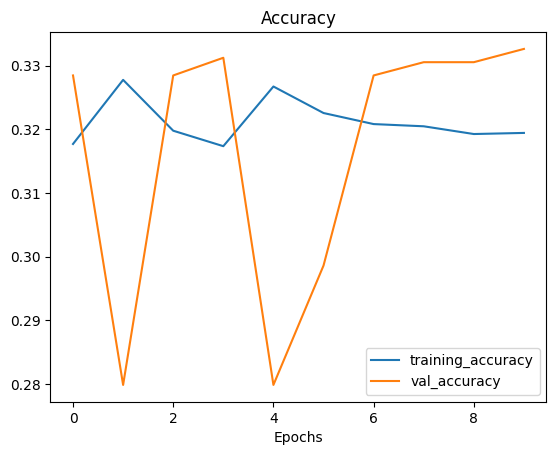

In [9]:
plot_loss_curves(history_tl_model_0)

### This model is not giving more accuracy so we can add some data aggmetation Layer on it ANd check whether it is affection g the model or after that we can unfreeze some weights

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

In [22]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False, weights="imagenet")
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(6, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
tf_model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
tf_model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



28456008/28456008 [==============================] - 109s 4us/step


In [23]:
# Train the model
history_tf_model_1 = tf_model_1.fit(
    train_images, train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="tf_model_1"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/tf_model_1/20231203-222431
Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 1.5889 - accuracy: 0.3031
Epoch 1: val_loss did not improve from 1.55891
180/180 [==============================] - 122s 638ms/step - loss: 1.5889 - accuracy: 0.3031 - val_loss: 1.5875 - val_accuracy: 0.3285
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 1.5855 - accuracy: 0.3208
Epoch 2: val_loss did not improve from 1.55891
180/180 [==============================] - 117s 650ms/step - loss: 1.5855 - accuracy: 0.3208 - val_loss: 1.5834 - val_accuracy: 0.3285
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 1.5832 - accuracy: 0.3172
Epoch 3: val_loss did not improve from 1.55891
180/180 [==============================] - 137s 764ms/step - loss: 1.5832 - accuracy: 0.3172 - val_loss: 1.5819 - val_accuracy: 0.3333
Epoch 4/5
180/180 [==============================] - ETA: 0s - loss: 1.5810 - accuracy: 0.3090
Epoch 4

In [20]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights= None)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(6, activation="softmax", name="output_layer")(x)
tl_model_1 = tf.keras.Model(inputs, outputs)

# Compile
tl_model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [21]:
# Train the model
history_tl_2_model_1 = tl_model_1.fit(
    train_images, train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="tl_model_1"),
                                             checkpoint_callbck])

Saving TensorBoard log files to: models/tl_model_1/20231203-212435
Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 1.6310 - accuracy: 0.3257
Epoch 1: val_loss did not improve from 1.57243
180/180 [==============================] - 95s 499ms/step - loss: 1.6310 - accuracy: 0.3257 - val_loss: 1.5764 - val_accuracy: 0.3285
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 1.5673 - accuracy: 0.3257
Epoch 2: val_loss improved from 1.57243 to 1.56309, saving model to models\checkpoint.ckpt
180/180 [==============================] - 108s 603ms/step - loss: 1.5673 - accuracy: 0.3257 - val_loss: 1.5631 - val_accuracy: 0.3285
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 1.5629 - accuracy: 0.3257
Epoch 3: val_loss improved from 1.56309 to 1.56135, saving model to models\checkpoint.ckpt
180/180 [==============================] - 186s 1s/step - loss: 1.5629 - accuracy: 0.3257 - val_loss: 1.5614 - val_accuracy: 0.3285
Epoch 4/5
180/180 

In [7]:
# Let's make create_model() function to model from a url
def create_model(model_url, num_classes=6):
  """
  Takes a tensorflow hub URL and creates a keras sequential model with it.

  Args:
    model_url(str): A tensorflow hub feature extraction URL.
    num_classes (int): Number of output nrurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layers = hub.KerasLayer(model_url,
                                            trainable=False, # Freeze the already learned pattarens
                                            name= "feature_extraction_layer",
                                            input_shape=(224,224,3)) # Freeze the already learned pattarens
  # cretae our own model
  model = tf.keras.Sequential([
      feature_extractor_layers,
      layers.Dense(num_classes, activation="softmax", name = "output_layer")
  ])

  return model


In [8]:
efficientnet_url= "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b1-feature-vector/versions/1"


In [9]:
efficientnet_model = create_model(model_url= efficientnet_url,
                                  num_classes=6)

In [10]:
# compile Efficientnet model
efficientnet_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [11]:
# Train the model
history_FE_model_9 = efficientnet_model.fit(
    train_images, train_labels,
    epochs=5,
    validation_data=(val_images, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = "models",
                                             experiment_name="FE_model_9"),
                                             checkpoint_callbck])


Saving TensorBoard log files to: models/FE_model_9/20231203-234909
Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.6736
Epoch 1: val_loss improved from inf to 0.70032, saving model to models\checkpoint.ckpt
180/180 [==============================] - 137s 717ms/step - loss: 0.8838 - accuracy: 0.6736 - val_loss: 0.7003 - val_accuracy: 0.7396
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7828
Epoch 2: val_loss improved from 0.70032 to 0.61251, saving model to models\checkpoint.ckpt
180/180 [==============================] - 146s 814ms/step - loss: 0.5941 - accuracy: 0.7828 - val_loss: 0.6125 - val_accuracy: 0.7736
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 0.5056 - accuracy: 0.8194
Epoch 3: val_loss improved from 0.61251 to 0.56149, saving model to models\checkpoint.ckpt
180/180 [==============================] - 149s 831ms/step - loss: 0.5056 - accuracy: 0.8194 - val_loss: 0.56